In [1]:
%matplotlib inline

import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

#==============================================================#

# Bit of a hack to install the cuda nifty gridder at runtime (not sure about integrating this into requirements.txt is all)
cuda_nifty_gridder = 'git+https://gitlab.com/ska-telescope/sdp/ska-gridder-nifty-cuda.git'
subprocess.check_call([sys.executable, "-m", "pip", "install", cuda_nifty_gridder])
import cuda_nifty_gridder as cng

#==============================================================#

def show_image(image, title, flip_x_axis=False):
    if flip_x_axis:
        image = np.fliplr(image)
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
#==============================================================#
    
def rrmse(observed, ideal):
    return np.sqrt((1 / observed.shape[0]**2) * np.sum((observed-ideal)**2) / np.sum(ideal**2)) * 100.0
    
#==============================================================#

  Cloning https://gitlab.com/ska-telescope/sdp/ska-gridder-nifty-cuda.git to /tmp/pip-req-build-nl841xsa


  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/sdp/ska-gridder-nifty-cuda.git /tmp/pip-req-build-nl841xsa


  Resolved https://gitlab.com/ska-telescope/sdp/ska-gridder-nifty-cuda.git to commit 9bca91a50828d8a5a428b2dcc3f0aa36c022da4f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [2]:
# Algorithm config
dataset_folder = "../datasets/gleam_small/"
vis_intensity_file = dataset_folder + "gleam_small_ts_bl_ch.vis"
vis_uvw_file =  dataset_folder + "gleam_small_ts_bl_ch.uvw"

image_size = 800
fov_degrees = 1.0
pixel_size_rads = np.arcsin(2.0 * np.sin(0.5 * fov_degrees * np.pi / 180.0) / image_size)
frequency_hz = np.array([140000000.0])
right_ascension = False

direct_imager_reference = dataset_folder + f"images/direct_image_ts_0_29_{image_size}x{image_size}.bin"
# solved_image_reference = dataset_folder + f"images/solved_image_{image_size}x{image_size}.bin"

In [3]:
# Data prep
vis_count_from_file = np.fromfile(vis_intensity_file, dtype=np.int32, count=1)[0]
# print(f"Visibility count according to file: {vis_count_from_file}")
uvw_count_from_file = np.fromfile(vis_uvw_file, dtype=np.int32, count=1)[0]
# print(f"UVW coord count according to file: {uvw_count_from_file}")

visibilities = np.fromfile(vis_intensity_file, dtype=np.float32, count=vis_count_from_file*2, offset=np.dtype(np.int32).itemsize)
visibilities = visibilities.reshape(vis_count_from_file, 2)
visibilities = np.vectorize(complex)(visibilities[:, 0], visibilities[:, 1])
visibilities = visibilities.reshape(visibilities.shape[0], 1)
visibilities = visibilities.astype(np.complex64)

uvw_coords = np.fromfile(vis_uvw_file, dtype=np.float32, count=uvw_count_from_file*3, offset=np.dtype(np.int32).itemsize)
uvw_coords = uvw_coords.reshape(uvw_count_from_file, 3)

if right_ascension:
    uvw_coords[:, 0] *= -1.0
    uvw_coords[:, 2] *= -1.0
    
weights = np.ones(vis_count_from_file, dtype=np.float32)

In [4]:
# Execution
result = cng.ms2dirty(
    uvw_coords,
    frequency_hz,
    visibilities,
    weights,
    image_size,
    image_size,
    pixel_size_rads,
    pixel_size_rads,
    0,
    0,
    1e-6, # single precision
    True
)

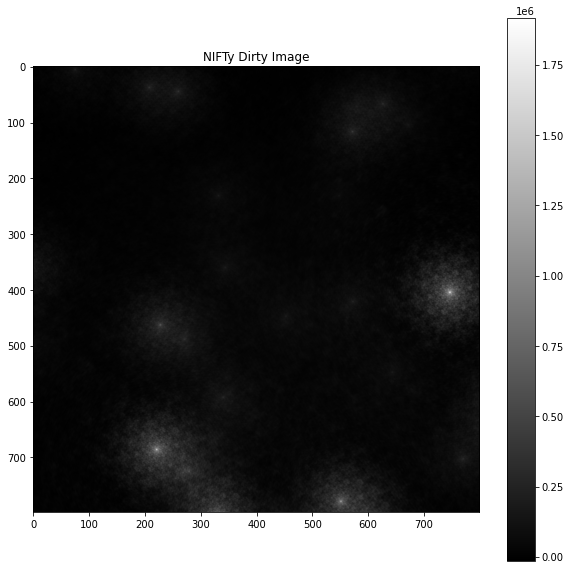

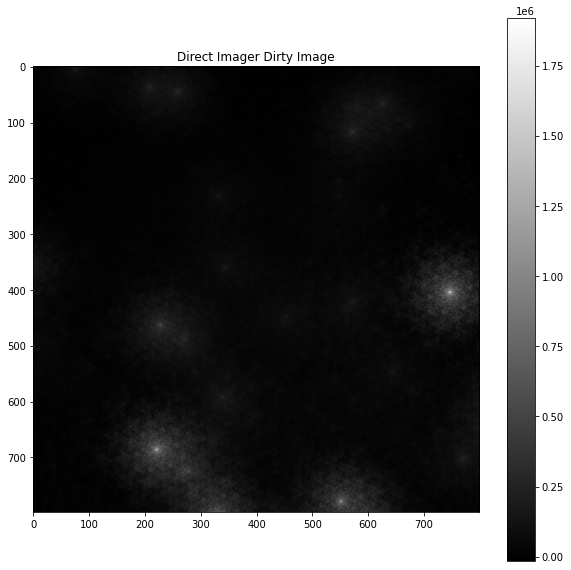

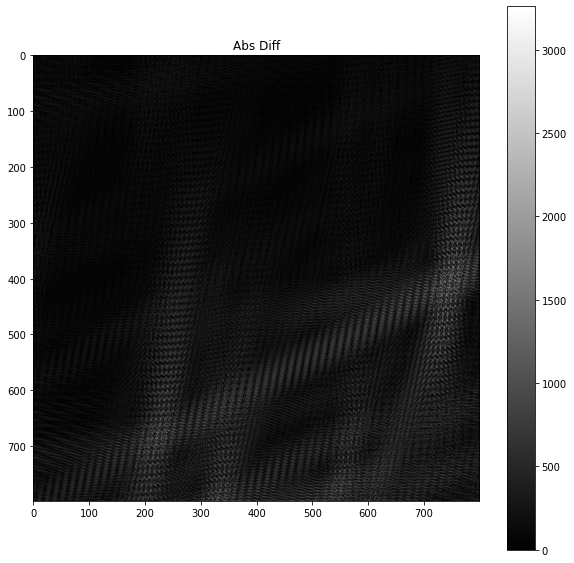

Result max: 1917875.75, row/col: (405, 746)
Actual max: 1921136.25, row/col: (405, 746)
RRMSE: 0.0004218010536185255


In [5]:
actual = np.fromfile(direct_imager_reference, dtype=np.float32).reshape(image_size, image_size)
actual = np.rot90(actual)

# solved = np.fromfile(solved_image_reference, dtype=np.float32).reshape(image_size, image_size)

# trimming due to rotational alignment error
result = result[1:, :]
actual = actual[:actual.shape[0]-1, :]

show_image(result, "NIFTy Dirty Image")
show_image(actual, "Direct Imager Dirty Image")
# show_image(solved, "Solved Dirty Image")
show_image(np.absolute(result - actual), "Abs Diff")

result_max = np.unravel_index(np.argmax(result, axis=None), result.shape)
print(f"Result max: {np.max(result)}, row/col: {result_max}")
actual_max = np.unravel_index(np.argmax(actual, axis=None), actual.shape)
print(f"Actual max: {np.max(actual)}, row/col: {actual_max}")
print(f"RRMSE: {rrmse(result, actual)}")

# Observations
# 1. Why does a low-resolution image have less overall "energy" than a higher-res image, specifically regarding IDFT
#    - Update: this seems consistent between nifty and direct imager, aside from slight differences due to technique accuracy
# 2. Why are sources not at the exact same pixel location?
#    - Update: I think this is to do with the way images are produced, nifty images appear to be rotated differently than direct imager, hence offset